In [2]:
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
import nltk
import pickle
from contextlib import contextmanager
import copy
import os
import re
import string
import time
import warnings
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import LatentDirichletAllocation
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from matplotlib import pyplot
from xgboost import plot_importance
from sklearn.metrics import roc_curve, auc
# Create a function to calculate the error metrics, since we'll be doing this several times
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Using TensorFlow backend.
/Users/kelvin/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/kelvin/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/kelvin/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/kelvin/anaconda3/lib/python3.7/site-packages/t

In [3]:
@contextmanager
def timer(msg):
    t0 = time.time()
    print(f'[{msg}] start.')
    yield
    elapsed_time = time.time() - t0
    print(f'[{msg}] done in {elapsed_time / 60:.2f} min.')

In [4]:
# Create a function to calculate the error metrics, since we'll be doing this several times
def conf_matrix(actual, predicted):
    cm = confusion_matrix(actual, predicted)
    ax = sns.heatmap(cm, xticklabels=['predicted_negative', 'predicted_positive'], 
                yticklabels=['actual_negative', 'actual_positive'], annot=True,
                fmt='d', annot_kws={'fontsize':20}, cmap="YlGnBu");
    
    true_neg, false_pos = cm[0]
    false_neg, true_pos = cm[1]
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
        
    accuracy = round((true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg),3)
    precision = round((true_pos) / (true_pos + false_pos),3)
    recall = round((true_pos) / (true_pos + false_neg),3)
    f1 = round(2 * (precision * recall) / (precision + recall),3)

    cm_results = [accuracy, precision, recall, f1]
    return cm_results

In [5]:
data = pd.read_csv('cleaned_short_simple.csv')

In [6]:
any(data.comment_text.isnull())

True

In [7]:
data.comment_text = data.comment_text.replace(np.nan, '')

In [8]:
x = data.comment_text
y = data.y

In [9]:
# Split the data into training and test sets
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42, stratify=y)

In [10]:
# Balance train set
x_balance, y_balance = RandomOverSampler().fit_sample(pd.DataFrame(x_train), y_train)

In [11]:
x_balance = x_balance.tolist()
x_balance = [x for [x] in x_balance]
x_balance = pd.DataFrame(x_balance)

In [13]:
x_balance = x_balance[0]

In [14]:
# The first document-term matrix has default Count Vectorizer values - counts of unigrams
from sklearn.feature_extraction.text import CountVectorizer

cv1 = CountVectorizer(stop_words='english', binary=True)

x_train_cv1 = cv1.fit_transform(x_balance)
x_test_cv1  = cv1.transform(x_test)

In [15]:
# The second document-term matrix has both unigrams and bigrams, and indicators instead of counts
cv2 = CountVectorizer(ngram_range=(1,2), binary=True, stop_words='english')

x_train_cv2 = cv2.fit_transform(x_balance)
x_test_cv2  = cv2.transform(x_test)

In [19]:
probabilities = []

In [22]:
# Create a logistic regression model to use
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
# Train the first model
lr.fit(x_train_cv1, y_balance)
y_pred_cv1 = lr.predict(x_test_cv1)
y_prob_log1 = lr.predict_proba(x_test_cv1)
probabilities.append(y_prob_log1)
# Train the second model
lr.fit(x_train_cv2, y_balance)
y_pred_cv2 = lr.predict(x_test_cv2)
y_prob_log2 = lr.predict_proba(x_test_cv2)
probabilities.append(y_prob_log2)

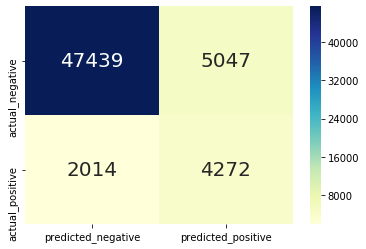

In [17]:
# The heat map for the first logistic regression model
cm1 = conf_matrix(y_test, y_pred_cv1)

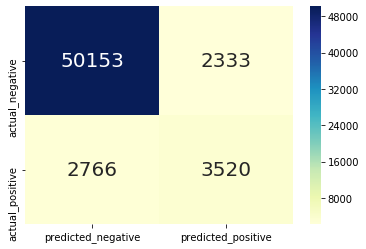

In [18]:
# The heat map for the second logistic regression model
cm2 = conf_matrix(y_test, y_pred_cv2)

In [22]:
# Fit the second Naive Bayes model
from sklearn.naive_bayes import BernoulliNB

bnb = BernoulliNB()
bnb.fit(x_train_cv1, y_balance)

y_pred_cv1_nb = bnb.predict(x_test_cv1)

In [23]:
bnb = BernoulliNB()
bnb.fit(x_train_cv2, y_balance)

y_pred_cv2_nb = bnb.predict(x_test_cv2)

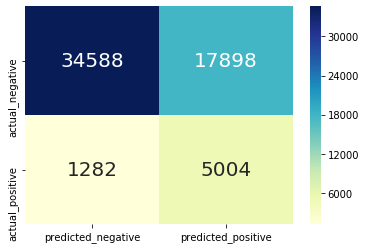

In [24]:
# Here's the heat map for the first Naive Bayes model
cm5 = conf_matrix(y_test, y_pred_cv1_nb)

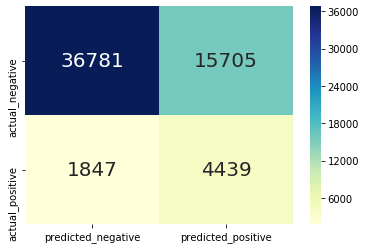

In [25]:
# Here's the heat map for the second Naive Bayes model
cm6 = conf_matrix(y_test, y_pred_cv2_nb)

In [26]:
# Compile all of the error metrics into a dataframe for comparison
results_nb = pd.DataFrame(list(zip(cm1, cm2, cm3, cm4, cm5, cm6)))
results_nb = results_nb.set_index([['Accuracy', 'Precision', 'Recall', 'F1 Score']])
results_nb.columns = ['LogReg1', 'LogReg2', 'NB1-Multi', 'NB2-Multi', 'NB1-Ber', 'NB2-Ber']
results_nb

,LogReg1,LogReg2,NB1-Multi,NB2-Multi,NB1-Ber,NB2-Ber
Accuracy,0.878,0.913,0.730,0.800,0.674,0.701
Precision,0.453,0.602,0.255,0.297,0.218,0.220
Recall,0.662,0.560,0.790,0.636,0.796,0.706
F1 Score,0.538,0.580,0.386,0.405,0.342,0.335


### Try using TF-IDF instead of Count Vectorizer

In [27]:
# Create TF-IDF versions of the Count Vectorizers created earlier in the exercise
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf1 = TfidfVectorizer(stop_words='english')
x_train_tfidf1 = tfidf1.fit_transform(x_balance)
x_test_tfidf1  = tfidf1.transform(x_test)

In [28]:
tfidf2 = TfidfVectorizer(ngram_range=(1,2), binary=True, stop_words='english')
x_train_tfidf2 = tfidf2.fit_transform(x_balance)
x_test_tfidf2  = tfidf2.transform(x_test)

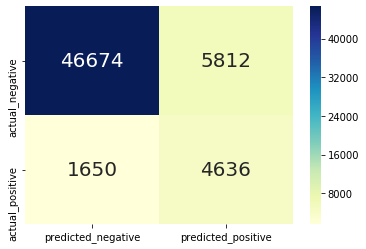

In [31]:
# Fit the first logistic regression on the TF-IDF data
lr.fit(x_train_tfidf1, y_balance)
y_pred_tfidf1_lr = lr.predict(x_test_tfidf1)
cm1 = conf_matrix(y_test, y_pred_tfidf1_lr)

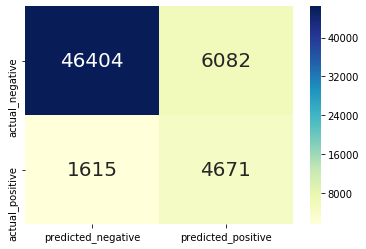

In [33]:
# Fit the first logistic regression on the TF-IDF data
lr.fit(x_train_tfidf2, y_balance)
y_pred_tfidf2_lr = lr.predict(x_test_tfidf2)
cm2 = conf_matrix(y_test, y_pred_tfidf2_lr)

In [38]:
# Fit the first Naive Bayes model
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB()
mnb.fit(x_train_tfidf1, y_balance)

y_pred_cv1_nb = mnb.predict(x_test_tfidf1)

In [39]:
mnb = MultinomialNB()
mnb.fit(x_train_tfidf2, y_balance)

y_pred_cv2_nb = mnb.predict(x_test_tfidf2)

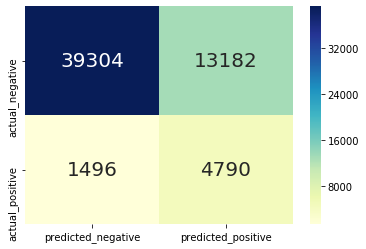

In [40]:
# Here's the heat map for the first Naive Bayes model
cm3 = conf_matrix(y_test, y_pred_cv1_nb)

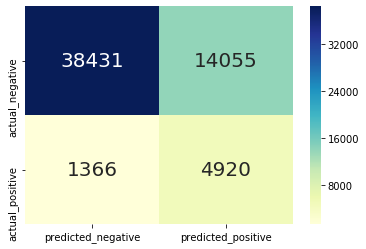

In [41]:
# Here's the heat map for the second Naive Bayes model
cm4 = conf_matrix(y_test, y_pred_cv2_nb)

In [43]:
# Fit the second Naive Bayes model
from sklearn.naive_bayes import BernoulliNB

bnb = BernoulliNB()
bnb.fit(x_train_tfidf1, y_balance)

y_pred_cv1_nb = bnb.predict(x_test_tfidf1)

In [44]:
bnb = BernoulliNB()
bnb.fit(x_train_tfidf2, y_balance)

y_pred_cv2_nb = bnb.predict(x_test_tfidf2)

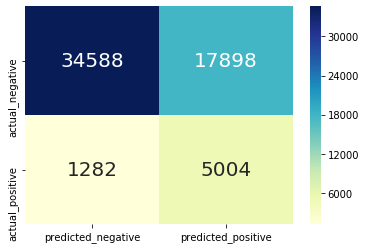

In [45]:
# Here's the heat map for the first Naive Bayes model
cm5 = conf_matrix(y_test, y_pred_cv1_nb)

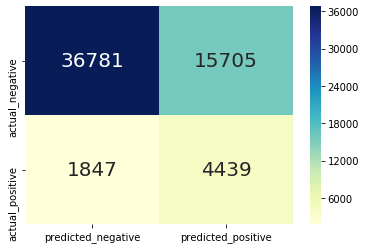

In [46]:
# Here's the heat map for the second Naive Bayes model
cm6 = conf_matrix(y_test, y_pred_cv2_nb)

In [48]:
import keras

In [60]:
deep_model = keras.Sequential([
    keras.layers.Dense(units=10, input_shape=(92719, ), name="hidden_layer"),
    keras.layers.Activation("relu", name="1_activation"),
    keras.layers.Dense(units=1, name="output_layer"),
    keras.layers.Activation("sigmoid", name="sigmoid_activation"),   
])
deep_model.compile(optimizer="nadam", loss="binary_crossentropy", metrics=["binary_accuracy"])

In [61]:
deep_model.fit(x_train_tfidf1,y_balance, epochs=3)
predict = deep_model.predict(x_test_tfidf1)
predict = np.where(predict >= 0.5, 1, 0)

Epoch 1/3
314918/314918 [==============================] - 438s 1ms/step - loss: 0.2680 - binary_accuracy: 0.8925
Epoch 2/3
314918/314918 [==============================] - 453s 1ms/step - loss: 0.1285 - binary_accuracy: 0.9539
Epoch 3/3
314918/314918 [==============================] - 513s 2ms/step - loss: 0.0662 - binary_accuracy: 0.9791


In [76]:
predict = deep_model.predict(x_test_tfidf1)
predict = np.where(predict >= 0.05, 1, 0)

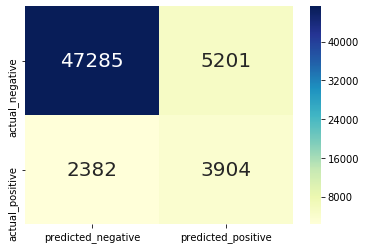

In [79]:
cm7 = conf_matrix(y_test, predict)

ROC_AUC:  0.7495832168883809


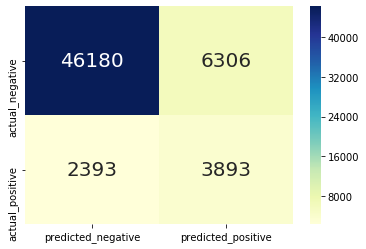

In [80]:
model = XGBClassifier()
model.fit(x_train_tfidf1, y_balance)
predict = model.predict(x_test_tfidf1)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predict)
roc_auc = auc(false_positive_rate, true_positive_rate)
print("ROC_AUC: ", roc_auc)
cm8 = conf_matrix(y_test, predict)

ROC_AUC:  0.7505307598411862


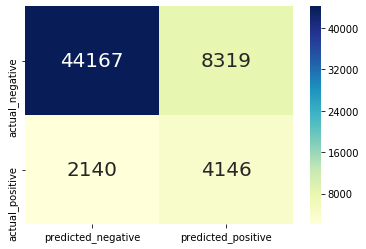

In [81]:
model = XGBClassifier()
model.fit(x_train_tfidf2, y_balance)
predict = model.predict(x_test_tfidf2)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predict)
roc_auc = auc(false_positive_rate, true_positive_rate)
print("ROC_AUC: ", roc_auc)
cm9 = conf_matrix(y_test, predict)

In [82]:
# Compile all of the error metrics into a dataframe for comparison
results_nb = pd.DataFrame(list(zip(cm1, cm2, cm3, cm4, cm5, cm6, cm7, cm8, cm9)))
results_nb = results_nb.set_index([['Accuracy', 'Precision', 'Recall', 'F1 Score']])
results_nb.columns = ['LogReg1', 'LogReg2', 'NB1-Multi', 'NB2-Multi', 'NB1-Ber', 'NB2-Ber', 'KerasClass', 'XGB1', 'XGB2']
results_nb

,LogReg1,LogReg2,NB1-Multi,NB2-Multi,NB1-Ber,NB2-Ber,KerasClass,XGB1,XGB2
Accuracy,0.873,0.869,0.750,0.738,0.674,0.701,0.871,0.852,0.822
Precision,0.444,0.434,0.267,0.259,0.218,0.220,0.429,0.382,0.333
Recall,0.738,0.743,0.762,0.783,0.796,0.706,0.621,0.619,0.660
F1 Score,0.554,0.548,0.395,0.389,0.342,0.335,0.507,0.472,0.443


# TDIDF

In [47]:
# Compile all of the error metrics into a dataframe for comparison
results_nb = pd.DataFrame(list(zip(cm1, cm2, cm3, cm4, cm5, cm6)))
results_nb = results_nb.set_index([['Accuracy', 'Precision', 'Recall', 'F1 Score']])
results_nb.columns = ['LogReg1', 'LogReg2', 'NB1-Multi', 'NB2-Multi', 'NB1-Ber', 'NB2-Ber']
results_nb

,LogReg1,LogReg2,NB1-Multi,NB2-Multi,NB1-Ber,NB2-Ber
Accuracy,0.873,0.869,0.750,0.738,0.674,0.701
Precision,0.444,0.434,0.267,0.259,0.218,0.220
Recall,0.738,0.743,0.762,0.783,0.796,0.706
F1 Score,0.554,0.548,0.395,0.389,0.342,0.335


# CV 

In [26]:
# Compile all of the error metrics into a dataframe for comparison
results_nb = pd.DataFrame(list(zip(cm1, cm2, cm3, cm4, cm5, cm6)))
results_nb = results_nb.set_index([['Accuracy', 'Precision', 'Recall', 'F1 Score']])
results_nb.columns = ['LogReg1', 'LogReg2', 'NB1-Multi', 'NB2-Multi', 'NB1-Ber', 'NB2-Ber']
results_nb

,LogReg1,LogReg2,NB1-Multi,NB2-Multi,NB1-Ber,NB2-Ber
Accuracy,0.878,0.913,0.730,0.800,0.674,0.701
Precision,0.453,0.602,0.255,0.297,0.218,0.220
Recall,0.662,0.560,0.790,0.636,0.796,0.706
F1 Score,0.538,0.580,0.386,0.405,0.342,0.335
